# Gray code encoding for ab initio interaction

In [1]:
import numpy as np
np.warnings.filterwarnings('ignore')

import pickle

from scipy.linalg import expm
# import scipy
from pprint import pprint
from tqdm import tqdm

from scipy.linalg import lstsq
import scipy as sp

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom

import qutip as qt
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set()

import itertools

import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *
from qiskit_experiment import *
from qite import *

## Playing with Pauli and WeightedPauli operators

In [2]:
## H is always in qiskit order (right to left)
## String form is also in that order 
## State vector results in order [00,01,10,11]
from scipy.linalg import eigh

J=1
Nmax=4
hw=1.0 ## reset by toy hamiltonian
basis=generate_relative_states(Nmax,J,L=0)
print(basis)
H = hamiltonian_matrix(Nmax=4,J=1,interaction="toy")
# print(H)

H_graycode=GrayCodeHamiltonian(H)

n_qubits=H_graycode.N_qubits
print("n qubits",n_qubits)


# print(H_graycode.N_qubits)
# print(H_graycode.state_order)
# print(H_graycode.permutation)
# print("pauli rep")
print(H_graycode.pauli_rep)
print("")
# p=_partition(H_graycode)
# print(p)
# print("")
# print(H_graycode.to_dict)
# print(H_graycode.pauli_partitions)
# print(H_graycode.matrix)
# print("")


eigs,_=eigh(H)
print("eigenvalues")
print(eigs)

{(0, 0, 1, 1, 0): 0, (2, 0, 1, 1, 0): 1, (4, 0, 1, 1, 0): 2}
n qubits 2
(7.7658547225+0j) [] +
(-2.1433035249352805+0j) [X0] +
(-2.1433035249352805+0j) [X0 Z1] +
(-7.9841452775+0j) [Z0] +
(3.913118960624632+0j) [Z0 X1] +
(1.6408547225000003+0j) [Z0 Z1] +
(-3.913118960624632+0j) [X1] +
(-1.8591452774999997+0j) [Z1]

eigenvalues
[-2.045671  8.561582 24.547508]


In [3]:
## vector of WeightedPauliOperators representing vector Sigma -- a list of all pauli terms with odd number of Y gates
sigmas=get_sigma_pauli_terms(n_qubits)

## b=i[H,sigma]
b_pauli_terms=b_terms(H_graycode,sigmas)

##S_{ij}=2sigma_i.sigma_j
S_pauli_terms=S_terms(sigmas)

## Set of all pauli terms needed to compute H, b, and S
pauli_set=get_intersection_pauli_terms(H_graycode,b_pauli_terms,S_pauli_terms)

## Organize pauli set into commuting sets of pauli operators 
commuting_sets=get_commuting_sets(pauli_set)
print("key, [paulis in set]")
for p in commuting_sets:
    print(p, commuting_sets[p])

key, [paulis in set]
XX ['XX', 'XI', 'II', 'IX']
XZ ['XZ', 'IZ']
YY ['YY', 'IY', 'YI']
ZY ['ZY', 'ZI']
ZX ['ZX']
XY ['XY']
YX ['YX']
YZ ['YZ']
ZZ ['ZZ']


In [4]:
#####################################       
# Prepare and run the evolution circuit
#####################################       
num_iterations=30
delta_time=0.01

Nmax=14
H = hamiltonian_matrix(Nmax=14,J=1,interaction="toy")

H_graycode=GrayCodeHamiltonian(H)
n_qubits=H_graycode.N_qubits

print("num qubits :",n_qubits)
initialization="single_state"

exact_eigenvalue,_=eigh(H)
print(exact_eigenvalue)

backend = 'statevector_simulator'
sv_energies,Ccoefs_sv=run_qite_experiment(H_graycode,num_iterations,delta_time,backend,initialization,A_threshold=1e-10,cstep=None)

threshold=1e-2
backend = 'qasm_simulator'
qasm_energies_gc,_=run_qite_experiment(H_graycode,num_iterations,delta_time,backend,initialization,A_threshold=threshold,cstep=1)




num qubits : 3
[-2.215038  2.521599  8.321433 16.327663 26.595576 39.959244 57.747928
 83.055014]


100%|██████████| 30/30 [00:54<00:00,  1.80s/it]


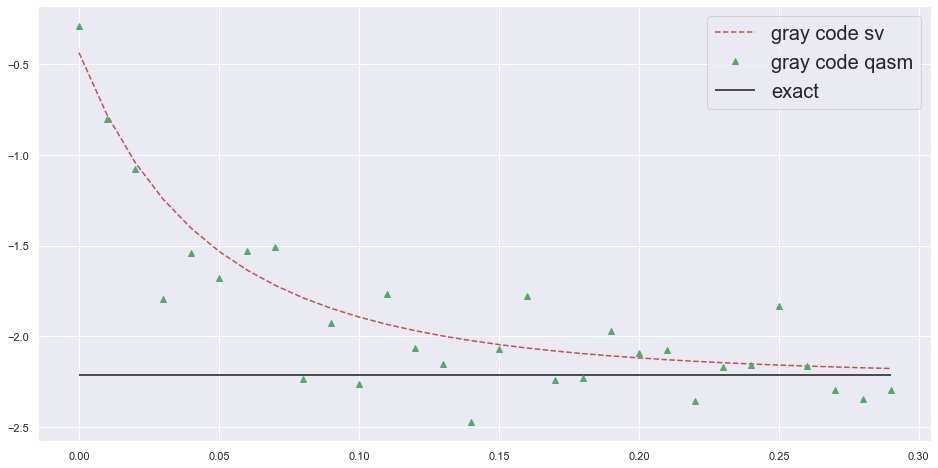

In [5]:
time=[delta_time*t for t in range(num_iterations)]
plt.plot(time,sv_energies,'r--',label="gray code sv")
plt.plot(time,qasm_energies_gc,'g^',label="gray code qasm")
plt.hlines(exact_eigenvalue[0], time[0], time[-1], colors='k', linestyles='solid', label='exact',)
plt.legend(prop={'size': 20})

In [6]:
Nmax=4
H = hamiltonian_matrix(Nmax=4,J=1,interaction="toy")
H_jw=JordanWignerHamiltonian(H)
print(H_jw.matrix)

eigsp,_= eigh(H_jw.matrix)
print("eigsp ",eigsp)
# print(H_jw.pauli_rep)
print(H_jw.pauli_coeffs)

print("")
print(H_jw.pauli_partitions)


[[-0.436581 -4.286607  0.      ]
 [-4.286607 12.25     -7.826238]
 [ 0.       -7.826238 19.25    ]]
eigsp  [-2.045671  8.561582 24.547508]
{'III': 15.531709445, 'IIZ': 0.21829055499999983, 'IXX': -2.1433035249352805, 'IYY': -2.1433035249352805, 'IZI': -6.125, 'XXI': -3.913118960624632, 'YYI': -3.913118960624632, 'ZII': -9.625}

{'ZZZ': ['III', 'IIZ', 'IZI', 'ZII'], 'XXX': ['IXX', 'XXI'], 'YYY': ['IYY', 'YYI']}


In [7]:
num_iterations=30
delta_time=0.01
initialization="uniform"
backend = 'statevector_simulator'
sv_energies_jw,_=run_qite_experiment(H_jw,num_iterations,delta_time,backend,initialization,A_threshold=1e-10,cstep=None)
print(sv_energies_jw)

100%|██████████| 30/30 [00:22<00:00,  1.31it/s]

[ 9.475287  6.397068  4.327324  2.977802  2.078862  1.446574  0.971775
  0.593798  0.279756  0.011708 -0.22053  -0.423193 -0.600522 -0.755733
 -0.891485 -1.010093 -1.113631 -1.203965 -1.282776 -1.351567 -1.411677
 -1.464286 -1.510427 -1.551002 -1.586793 -1.618474 -1.646625 -1.671743
 -1.694253 -1.714516]


[-2.045671  8.561582 24.547508]


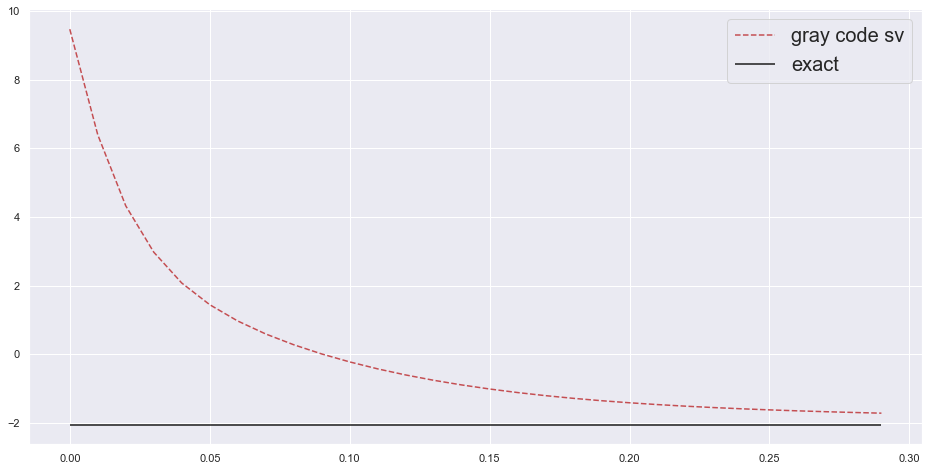

In [8]:
exact_eigenvalue,_=eigh(H)
print(exact_eigenvalue)

time=[delta_time*t for t in range(num_iterations)]
plt.plot(time,sv_energies_jw,'r--',label="gray code sv")
plt.hlines(exact_eigenvalue[0], time[0], time[-1], colors='k', linestyles='solid', label='exact',)
plt.legend(prop={'size': 20})

In [9]:
## vector of WeightedPauliOperators representing vector Sigma -- a list of all pauli terms with odd number of Y gates
n_qubits=H_jw.N_qubits
sigmas=get_sigma_pauli_terms(n_qubits)

## b=i[H,sigma]
b_pauli_terms=b_terms(H_jw,sigmas)

##S_{ij}=2sigma_i.sigma_j
S_pauli_terms=S_terms(sigmas)

## Set of all pauli terms needed to compute H, b, and S
pauli_set=get_intersection_pauli_terms(H_jw,b_pauli_terms,S_pauli_terms)

## Organize pauli set into commuting sets of pauli operators 
commuting_sets=get_commuting_sets(sorted(pauli_set))
print("key, [paulis in set]")
for p in commuting_sets:
    print(p, commuting_sets[p])

key, [paulis in set]
XXX ['III', 'IIX', 'IXI', 'IXX', 'XII', 'XIX', 'XXI', 'XXX']
XXY ['IIY', 'IXY', 'XIY', 'XXY']
XXZ ['IIZ', 'IXZ', 'XIZ', 'XXZ']
XYX ['IYI', 'IYX', 'XYI', 'XYX']
XYY ['IYY', 'XYY']
XYZ ['IYZ', 'XYZ']
XZX ['IZI', 'IZX', 'XZI', 'XZX']
XZY ['IZY', 'XZY']
XZZ ['IZZ', 'XZZ']
YXX ['YII', 'YIX', 'YXI', 'YXX']
YXY ['YIY', 'YXY']
YXZ ['YIZ', 'YXZ']
YYX ['YYI', 'YYX']
YYY ['YYY']
YYZ ['YYZ']
YZX ['YZI', 'YZX']
YZY ['YZY']
YZZ ['YZZ']
ZXX ['ZII', 'ZIX', 'ZXI', 'ZXX']
ZXY ['ZIY', 'ZXY']
ZXZ ['ZIZ', 'ZXZ']
ZYX ['ZYI', 'ZYX']
ZYY ['ZYY']
ZYZ ['ZYZ']
ZZX ['ZZI', 'ZZX']
ZZY ['ZZY']
ZZZ ['ZZZ']


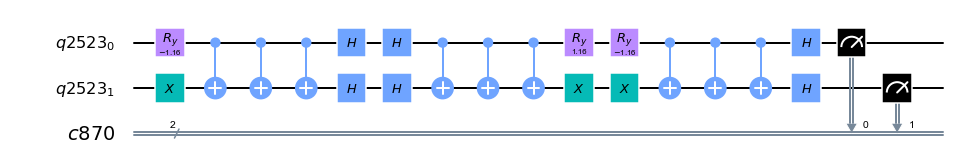

In [10]:
## Testing
N_states=2
encoding="JordanWigner"
N_qubits = N_states

measurement_idx="X"*N_qubits
thetas = np.random.uniform(low=-np.pi/2, high=np.pi/2,size=N_states-1)

circuit=variational_circuit(encoding,thetas,measurement_idx,"qasm_simulator",num_cnot_pairs=1,num_folding=1)
circuit.draw(output="mpl",filename="circuit.pdf")


In [5]:
backend=Aer.get_backend("statevector_simulator")
hw=1.0 ## Set internally by toy hamilonian
J=1
Nmax=2
# encoding="Graycode"
encoding="JordanWigner"
H = hamiltonian_matrix(Nmax=2,J=1,interaction="toy")

if encoding=="Graycode":
    H_qubit=GrayCodeHamiltonian(H)
else:
    H_qubit=JordanWignerHamiltonian(H)
# print(H_graycode.pauli_partitions.keys())
N_states = H_qubit.N_states
N_qubits = H_qubit.N_qubits 

# thetas = np.random.uniform(low=-np.pi/2, high=np.pi/2,size=N_states-1)
print(N_states)
thetas=[1.0]

energy=compute_energy(thetas, backend, H_qubit)


print(H_qubit.pauli_rep)
# print(H_qubit.pauli_partitions)
print("")
print(energy)

2
5.906709445000001 [] +
-2.1433035249352805 [X0 X1] +
-2.1433035249352805 [Y0 Y1] +
0.21829055499999983 [Z0] +
-6.125 [Z1]

5.72694850291904


In [6]:
from qiskit_experiment import set_parameters
hw=1.0 ## Set internally by toy hamilonian
J=1
Nmax=4
# encoding="Graycode"
encoding="JordanWigner"
H = hamiltonian_matrix(Nmax=4,J=1,interaction="toy")

if encoding=="Graycode":
    H_qubit=GrayCodeHamiltonian(H)
else:
    H_qubit=JordanWignerHamiltonian(H)

print(H_qubit.pauli_rep)
N_states = H_qubit.N_states
print(N_states)
N_qubits = H_qubit.N_qubits 
# thetas = np.random.uniform(low=-np.pi/2, high=np.pi/2,size=N_states-1)
# thetas=[1.0]
N_trials=1
thetas=[[1.0]*(N_states-1)]*N_trials

parameters = {
# "encoding": 'gray_code',
"encoding": 'jordan_wigner', 
"N_states": 3,
# "backend": 'statevector_simulator',
"backend": 'qasm_simulator',
"N_shots": 10000,
"N_cpus": 1,
"spsa_a": 0.628,
"spsa_c": 0.1,
"N_iter": 100,
"optimizer": 'SPSA',
"N_trials": N_trials,
"device_name": None,
"mitigate_meas_error": False,
"number_cnot_pairs": 4,
"zero_noise_extrapolation":True,
"output_dir": 'outputs-qiskit-statevector_simulator'
}
set_parameters(parameters)
# print(H_qubit.pauli_partitions)
energies=[]
for theta in thetas:
    res=do_experiment(theta,H_qubit,parameters)
    energies.append(res["fun"])
print(energies)

15.531709445 [] +
-2.1433035249352805 [X0 X1] +
-2.1433035249352805 [Y0 Y1] +
0.21829055499999983 [Z0] +
-3.913118960624632 [X1 X2] +
-3.913118960624632 [Y1 Y2] +
-6.125 [Z1] +
-9.625 [Z2]
3
No value for parameter layout provided.
Setting layout to default value None.
No value for parameter number_circuit_folding provided.
Setting number_circuit_folding to default value 0.

Experiment parameters
{'N_cpus': 1,
 'N_iter': 100,
 'N_shots': 10000,
 'N_states': 3,
 'N_trials': 1,
 'backend': 'qasm_simulator',
 'device_name': None,
 'encoding': 'jordan_wigner',
 'layout': None,
 'mitigate_meas_error': False,
 'number_circuit_folding': 0,
 'number_cnot_pairs': 4,
 'optimizer': 'SPSA',
 'output_dir': 'outputs-qiskit-statevector_simulator',
 'spsa_a': 0.628,
 'spsa_c': 0.1,
 'zero_noise_extrapolation': True}

[-1.8498541834547504]
